# CM50266 Applied Data Science
## Lab 2: Sentiment Analysis of Reviews
### Stephen Charles

### Data
You are provided with a large dataset of reviews for Ford motor vehicles (car_reviews.csv) on Moodle. Each review is labelled with either ‘Pos’ or ‘Neg’ to indicate whether the review has been assessed as positive or negative in the sentiment it expresses. You should treat these labels as a reliable indicator of sentiment. You can assume that there are no neutral reviews. There are 1,382 reviews in the CSV file in total, 691 of which are positive and 691 of which are negative.

***

# Task 1

***

In a Jupyter notebook, implement a Naïve Bayes classifier using 80% (1106) of the reviews as training data. The training data should be selected at random from the full dataset. Test your classifier using the remaining 20% (276) of the reviews and report the classifier’s performance using a confusion matrix.
It is important that you avoid issues of data leakage1, meaning that your classifier should only be trained using data that it has access to from within the training data set. If there are words that only appear in the test data they should not be part of the classifier. You will need to make sure that your code is able to deal with encountering words in the test data that the classifier has not seen in the training data. It is up to you to decide how you will handle this.
Your code will need to read the review data CSV file provided. For this you are free to use either the CSV reader that you implemented for Lab 1, or any other CSV reading library that you wish (e.g. Pandas).

You will need to perform some clean up of the data before using it in your classifier. This should include:

- Identifying and excluding all punctuation and words that are not likely to affect sentiment (e.g. stopwords2). As an example, Natural Language Toolkit (NLTK) in Python has lists of common stopwords that you may wish to use, but you are also free to find and use other libraries or tools for this.
- Ensuring that remaining words are not case sensitive (i.e. the classifier should not distinguish upper/lower case characters).

Your sentiment classifier should use a bag of words technique3, in which you build a vocabulary of individual words that appear in the dataset once it has been cleaned up.
You should attempt to treat minor variations of a word (e.g. ‘fault’, ‘faults’ and ‘faulty’) as instances of the same word (e.g. ‘fault’) when you are using them in your classifier. You should investigate and implement stemming as a way of doing this.

For each review you should create a vector as input for your classifier, containing EITHER binary values indicating whether a word/stem occurs in the review OR a numerical count of the number of times each word/stem appears. As described above, vectors that are used to train the classifier should only include words that appear in the training data (and not words that only exist within the test data).
Note: You do not need to code everything required from scratch. For this lab exercise you are encouraged to make use of existing libraries for all parts of the tasks. For example, you may find the MultinomialNB classifier in scikit.learn and natural language processing tools such as NLTK and spaCy useful for this task.
It is also important to note that there is no single correct answer in terms of the output and performance of your classifier. This will depend on the choices you make about how you deal with the data at each stage of the process – your markers will not be looking for a specific level of performance, rather that you have taken appropriate steps and implemented them correctly.

Your program will be assessed according to the following criteria:
- [x] Does the code produce some output (e.g. using print function) to clearly demonstrate that words and punctuation, which are unlikely to affect sentiment, have been excluded from the sentiment classifier AND that the remaining words are not being handled in a case sensitive way?
- [x] Does the code produce some output, which clearly demonstrates that words with the same stem have been appropriately recognised and treated as variations of the stem? This should be demonstrated for at least 3 different stems.
- [x] Does the code produce some output to demonstrate that a vector has been created for each review, where each element in the vector represents EITHER a binary variable indicating the presence of a word/stem in a review OR the number of times that a word (or word stem) appears? Note that the output does not need to show the vector for all reviews, this only needs to contain a small sample of reviews.
- [x] Does the code clearly show that an appropriate Naïve Bayes model has been used for classification, either through the use of an existing library or coded from scratch.
- [x] Does the code clearly show that 80% of the data has been used to train the classification model, and that the remaining 20% of the data set has been used as test data? AND does it show that only the training data has been used up to the point where the model has been trained? AND is the code able to cope with words that appear in the test data but not in the training dataset?
- [x] Does the code output a confusion matrix demonstrating the performance of the Naïve 1 Bayes classifier? The confusion matrix must clearly indicate the proportion of True
Negatives, False Positives, False Negatives and True Positives.


In [383]:
import pandas as pd
import numpy as np
import pickle

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tqdm import tqdm

from collections import Counter
import string

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
sns.set()

# Preprocessing

In [384]:
def process_text(filename):
    df = pd.read_csv(filename)
    stop_words = stopwords.words('english')

    # Remove Punctuation and Digits and make lowercase, Remove words < len(4)
    list_of_chars_and_digits = string.punctuation + string.digits
    df['remove_punc_and_digits'] = df['Review'].astype(str).str.replace(f"[{list_of_chars_and_digits}]", " ", regex=True).apply(str.lower).str.findall("\w{3,}").str.join(" ")

    # Tokenize the words, and remove stopwords
    df['word_tokens'] = [nltk.word_tokenize(df['remove_punc_and_digits'][row]) for row in range(df['remove_punc_and_digits'].shape[0])]
    df['remove_stopwords'] = [[word for word in df['word_tokens'][row] if word not in stop_words] for row in range(df['word_tokens'].shape[0])]
    df['remove_stopwords_count'] = [Counter(i) for i in df['remove_stopwords']]
    
    # Stem the words
    ps = PorterStemmer()
    df['stemmed'] = [[ps.stem(word) for word in df['remove_stopwords'][row]] for row in range(df['remove_stopwords'].shape[0])]
    df['stemmed_count'] = [Counter(i) for i in df['stemmed']]
    
    # Final processed sentence
    df['stemmed_sentence'] = [' '.join(i) for i in df['stemmed']]
    return df

df = process_text('car_reviews.csv')
df


,Sentiment,Review,remove_punc_and_digits,word_tokens,remove_stopwords,remove_stopwords_count,stemmed,stemmed_count,stemmed_sentence
0,Neg,In 1992 we bought a new Taurus and we really ...,bought new taurus and really loved decided try...,"[bought, new, taurus, and, really, loved, deci...","[bought, new, taurus, really, loved, decided, ...","{'bought': 2, 'new': 3, 'taurus': 3, 'really':...","[bought, new, tauru, realli, love, decid, tri,...","{'bought': 2, 'new': 3, 'tauru': 3, 'realli': ...",bought new tauru realli love decid tri new tau...
1,Neg,The last business trip I drove to San Franci...,the last business trip drove san francisco wen...,"[the, last, business, trip, drove, san, franci...","[last, business, trip, drove, san, francisco, ...","{'last': 1, 'business': 2, 'trip': 7, 'drove':...","[last, busi, trip, drove, san, francisco, went...","{'last': 1, 'busi': 2, 'trip': 7, 'drove': 1, ...",last busi trip drove san francisco went hertz ...
2,Neg,My husband and I purchased a 1990 Ford F250 a...,husband and purchased ford and had nothing but...,"[husband, and, purchased, ford, and, had, noth...","[husband, purchased, ford, nothing, problems, ...","{'husband': 1, 'purchased': 1, 'ford': 2, 'not...","[husband, purchas, ford, noth, problem, own, v...","{'husband': 1, 'purchas': 1, 'ford': 2, 'noth'...",husband purchas ford noth problem own vehicl a...
3,Neg,I feel I have a thorough opinion of this truc...,feel have thorough opinion this truck compared...,"[feel, have, thorough, opinion, this, truck, c...","[feel, thorough, opinion, truck, compared, pos...","{'feel': 1, 'thorough': 1, 'opinion': 1, 'truc...","[feel, thorough, opinion, truck, compar, post,...","{'feel': 1, 'thorough': 1, 'opinion': 1, 'truc...",feel thorough opinion truck compar post evalu ...
4,Neg,AS a mother of 3 all of whom are still in ca...,mother all whom are still carseats the only lo...,"[mother, all, whom, are, still, carseats, the,...","[mother, still, carseats, logical, thing, trad...","{'mother': 1, 'still': 1, 'carseats': 1, 'logi...","[mother, still, carseat, logic, thing, trade, ...","{'mother': 1, 'still': 1, 'carseat': 1, 'logic...",mother still carseat logic thing trade minivan...
...,...,...,...,...,...,...,...,...,...
1377,Pos,In June we bought the Sony Limited Edition Fo...,june bought the sony limited edition focus sed...,"[june, bought, the, sony, limited, edition, fo...","[june, bought, sony, limited, edition, focus, ...","{'june': 1, 'bought': 2, 'sony': 6, 'limited':...","[june, bought, soni, limit, edit, focu, sedan,...","{'june': 1, 'bought': 2, 'soni': 6, 'limit': 4...",june bought soni limit edit focu sedan simpli ...
1378,Pos,After 140 000 miles we decided to replace my...,after miles decided replace wife toyota camry ...,"[after, miles, decided, replace, wife, toyota,...","[miles, decided, replace, wife, toyota, camry,...","{'miles': 1, 'decided': 1, 'replace': 1, 'wife...","[mile, decid, replac, wife, toyota, camri, fou...","{'mile': 1, 'decid': 1, 'replac': 2, 'wife': 2...",mile decid replac wife toyota camri found new ...
1379,Pos,The Ford Focus is a great little record setti...,the ford focus great little record setting car...,"[the, ford, focus, great, little, record, sett...","[ford, focus, great, little, record, setting, ...","{'ford': 4, 'focus': 4, 'great': 4, 'little': ...","[ford, focu, great, littl, record, set, car, f...","{'ford': 4, 'focu': 4, 'great': 4, 'littl': 2,...",ford focu great littl record set car first car...
1380,Pos,I needed a new car because my hyundai excel 9...,needed new car because hyundai excel had decid...,"[needed, new, car, because, hyundai, excel, ha...","[needed, new, car, hyundai, excel, decided, sh...","{'needed': 1, 'new': 1, 'car': 14, 'hyundai': ...","[need, new, car, hyundai, excel, decid, shop, ...","{'need': 2, 'new': 1, 'car': 15, 'hyundai': 1,...",need new car hyundai excel decid shop around n...


In [385]:
print('Review unprocessed:\n')
print(f"{df['Review'][0]}\n")
print('Remove punctuation, digits, short words and make lowercase:\n')
print(f"{df['remove_punc_and_digits'][0]}\n")
print('Tokenized words:\n')
print(f"{df['word_tokens'][0]}\n")
print('Stopwords removed:\n')
print(f"{df['remove_stopwords'][0]}\n")
print('Stemmed words:\n')
print(f"{df['stemmed'][0]}\n")
print('Review fully processed:\n')
print(f"{df['stemmed_sentence'][0]}\n")


Review unprocessed:

 In 1992 we bought a new Taurus and we really loved it  So in 1999 we decided to try a new Taurus  I did not care for the style of the newer version  but bought it anyway I do not like the new car half as much as i liked our other one  Thee dash is much to deep and takes up a lot of room  I do not find the seats as comfortable and the way the sides stick out further than the strip that should protect your card from denting It drives nice and has good pick up  But you can not see the hood at all from the driver seat and judging and parking is difficult  It has a very small gas tank I would not buy a Taurus if I had it to do over  I would rather have my 1992 back  I don t think the style is as nice as the the 1992  and it was a mistake to change the style  In less than a month we had a dead battery and a flat tire 

Remove punctuation, digits, short words and make lowercase:

bought new taurus and really loved decided try new taurus did not care for the style the new

In [386]:
print('Stopwords count:\n')
print(f"{df['remove_stopwords_count'][0]}\n")
print('Stemmed count:\n')
print(f"{df['stemmed_count'][0]}\n")

Stopwords count:

Counter({'new': 3, 'taurus': 3, 'style': 3, 'bought': 2, 'much': 2, 'nice': 2, 'would': 2, 'really': 1, 'loved': 1, 'decided': 1, 'try': 1, 'care': 1, 'newer': 1, 'version': 1, 'anyway': 1, 'like': 1, 'car': 1, 'half': 1, 'liked': 1, 'one': 1, 'thee': 1, 'dash': 1, 'deep': 1, 'takes': 1, 'lot': 1, 'room': 1, 'find': 1, 'seats': 1, 'comfortable': 1, 'way': 1, 'sides': 1, 'stick': 1, 'strip': 1, 'protect': 1, 'card': 1, 'denting': 1, 'drives': 1, 'good': 1, 'pick': 1, 'see': 1, 'hood': 1, 'driver': 1, 'seat': 1, 'judging': 1, 'parking': 1, 'difficult': 1, 'small': 1, 'gas': 1, 'tank': 1, 'buy': 1, 'rather': 1, 'back': 1, 'think': 1, 'mistake': 1, 'change': 1, 'less': 1, 'month': 1, 'dead': 1, 'battery': 1, 'flat': 1, 'tire': 1})

Stemmed count:

Counter({'new': 3, 'tauru': 3, 'style': 3, 'bought': 2, 'like': 2, 'much': 2, 'seat': 2, 'nice': 2, 'would': 2, 'realli': 1, 'love': 1, 'decid': 1, 'tri': 1, 'care': 1, 'newer': 1, 'version': 1, 'anyway': 1, 'car': 1, 'half': 1,

# Train Test Split the data

In [387]:
# Sentiment target, convert to 1 for pos, 0 for neg
y = df['Sentiment'].replace('Pos', 1).replace('Neg', 0)
# Fully processed sentence
X = df['stemmed_sentence']

# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        train_size=0.8, test_size=0.2,
                                        random_state=0)

# Bag of Words features

In [388]:
vect = CountVectorizer()

X_train_bow = vect.fit_transform(X_train)
X_test_bow = vect.transform(X_test)

# Confusion Matrix

Confusion Matrix:

[[113  37]
 [ 29  98]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       150
           1       0.73      0.77      0.75       127

    accuracy                           0.76       277
   macro avg       0.76      0.76      0.76       277
weighted avg       0.76      0.76      0.76       277



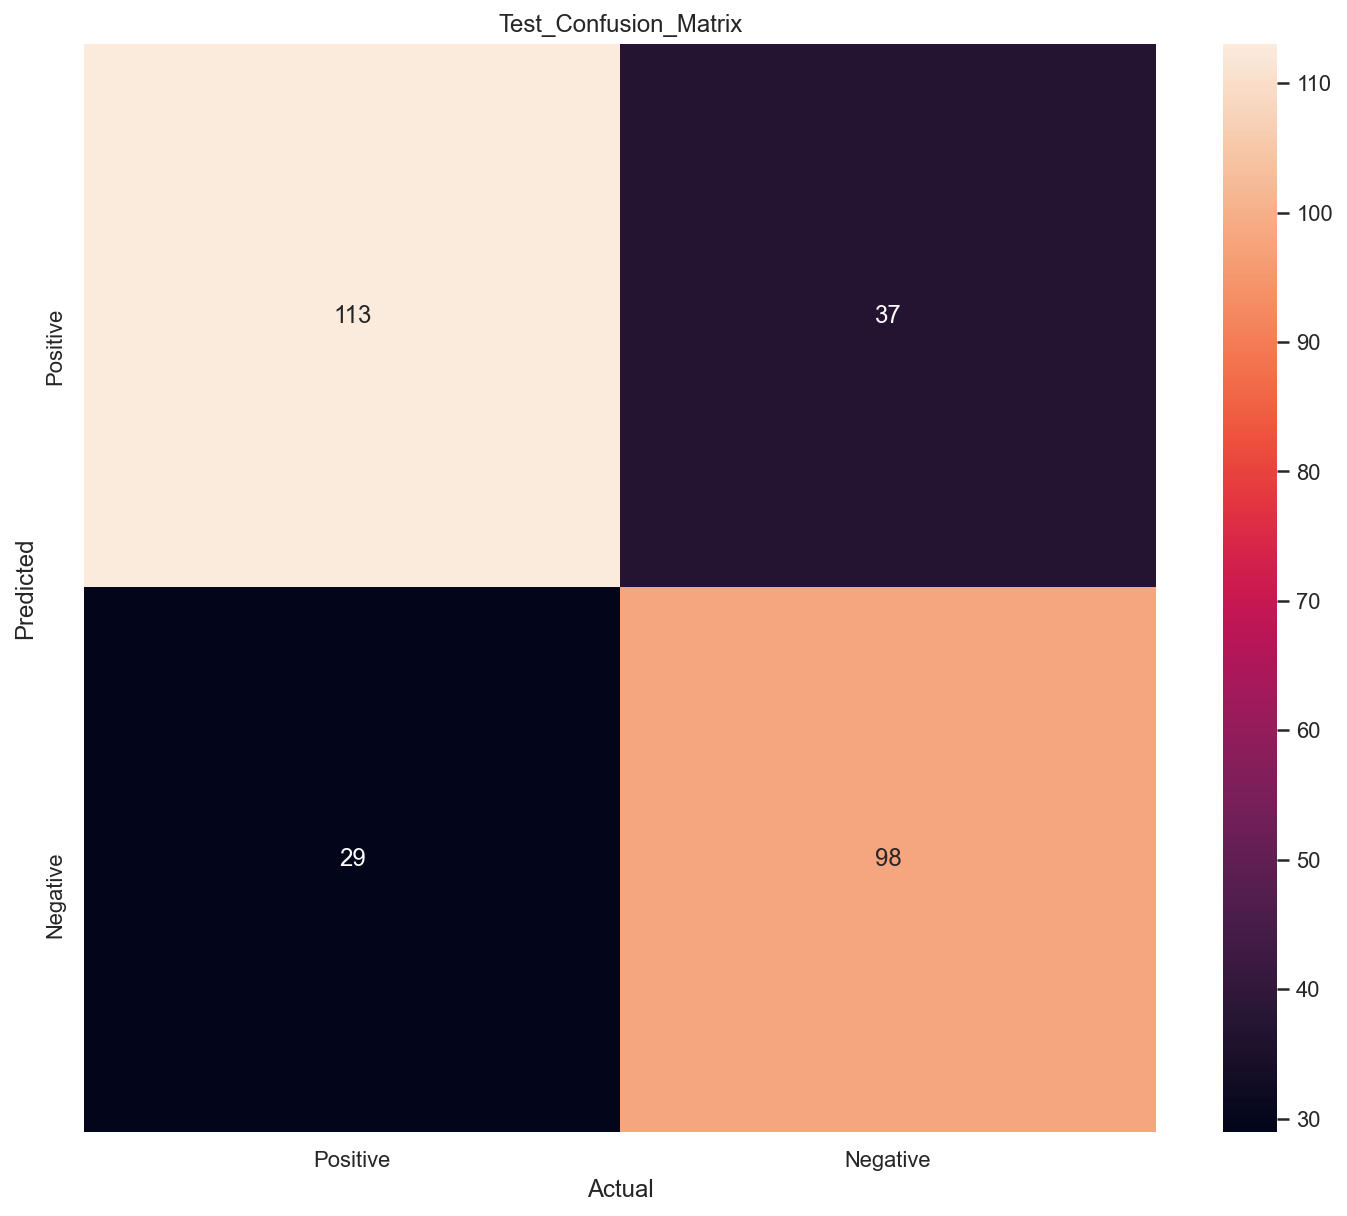

In [389]:
def matrix(X_train,y_train,X_test,y_test, alpha=10):

    # Run the model on the training set
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train, y_train)

    # Test the model with the test set
    predict = model.predict(X_test)

    # Save the model
    # pickle.dump(model, open('model.pkl','wb'))

    # Define the confusion matrix
    conf_mat = confusion_matrix(y_test, predict)
    print('Confusion Matrix:\n')
    print(conf_mat)
    class_label = ["Positive", "Negative"]
    df = pd.DataFrame(conf_mat, index=class_label, columns=class_label)

    # Get the classification report
    report = classification_report(y_test,predict)
    print(report)

    # Plot the confusion matrix
    plt.subplots(figsize=(12,10))
    sns.heatmap(df, annot=True, fmt="d")
    plt.title("Test_Confusion_Matrix")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

matrix(X_train_bow, y_train, X_test_bow, y_test)

# Top Features

In [390]:
def top_features():
    # Run the model
    model = MultinomialNB()
    model.fit(X_train_bow, y_train)
    
    # Get the top 10 pos 
    feature_names = vect.get_feature_names()
    a = getattr(model, 'feature_log_prob_')
    top_pos = list(zip(a[1], feature_names))
    top_pos.sort(key=lambda x: x[0])
    l = len(top_pos)
    print('\nThe Top 10 Positive Class Features are:\n')
    for i in range(1,11):
        print(top_pos[l-i][1])
    
    # Get the top 10 neg 
    top_neg = list(zip(a[0], feature_names))
    top_neg.sort(key=lambda x: x[0])
    l = len(top_neg)
    print('\nThe Top 10 Negative Class Features are:\n')
    for i in range(1,11):
        print(top_neg[l-i][1])

top_features()


The Top 10 Positive Class Features are:

car
ford
drive
seat
like
truck
one
get
vehicl
look

The Top 10 Negative Class Features are:

car
ford
like
problem
get
drive
one
vehicl
seat
would


***

# Task 2

***

Identify and research a way to improve on your solution to Task 1, that you would expect to do better at classifying the sentiment of the reviews.
You may either:
- Identify an alternative classification algorithm, or
- Apply modifications to the Naïve Bayes implementation, for example trying different classification of different size n-grams (multi-word phrases). Implement this improvement and compare the results to your initial Naïve Bayes classifier.

Note that it is does not matter if your approach for Task 2 does not actually outperform the approach you have taken in Task 1. You will not lose marks if the performance does not improve, however you must consider and explain why this might be the case when you are addressing the final criterion below.

Your solutions will be assessed according to the following criteria:
- [x] Does the Jupyter notebook include a markdown/comment section that clearly explains how the approach taken in Task 2 is expected to improve on the solution to Task 1. Are the reasons for the expected improvements clearly justified and explained with a references (e.g. to a published source scientific paper, article, book) ?
- [x] Does the code include comments that clearly explain the steps that have been taken to implement the improved approach? These should be written in a way that one of your peers who may not have researched the same approach could understand.
- [x] Does the code implement the described approach appropriately? (i.e. does the code 1 actually do what is described?)
- [x] Does the code output a new classification matrix for the “improved” Task 2 approach AND Is there markdown or comment that clearly discusses and compares the performance of the Task 1 and Task 2 classification approaches and explains whether or not the expected improvements were achieved (and why this may be the case).


# Plans for Improvement

- The first step to improve a model is the correct choice of hyperparameters. Using the `KFold()` and `GridSearch()` classes we can optimise the various parameters associated with the model `MultinomialNB()`. Naive Bayes models only have the alpha parameter to optimise, so we begin across a range of values.
- Other factors such as word vectorising in the pre-processing stage, rather than the bag of words approach could yield different results.
- Using `DictVectorizer()` could also improve the model, from the stemmed_counts column in preprocessing.
- Words which appear only once don't help classification at all, if only because they can never be matched again. More generally, words which appear rarely are more likely to appear by chance, so using them as features causes overfitting.

***

# Hyperparameter Tuning using `KFold()` and `GridSearch()`

Implemented improvements:
- Hyperparameter tuning for alpha.

We use the `KFold()` and `GridSearch()` to find the optimal alpha value for our model.

In [391]:
def param_tuning(X_train):
    cv = KFold(n_splits=5) # defining the K-fold cross validation
    model = MultinomialNB()
    parameters = {'alpha':alpha_values}
    clf = GridSearchCV(model,parameters, cv=cv, scoring='roc_auc',return_train_score=True,verbose=1)
    clf.fit(X_train, y_train)
    return clf

alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = param_tuning(X_train_bow)
# defining train and cross_validation
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std = clf.cv_results_['std_test_score']
best_alpha = clf.best_params_['alpha']

Fitting 5 folds for each of 11 candidates, totalling 55 fits


Below is a plot displaying all of the respective K-folds and fitted alpha values, with the best alpha value obtained around 1.

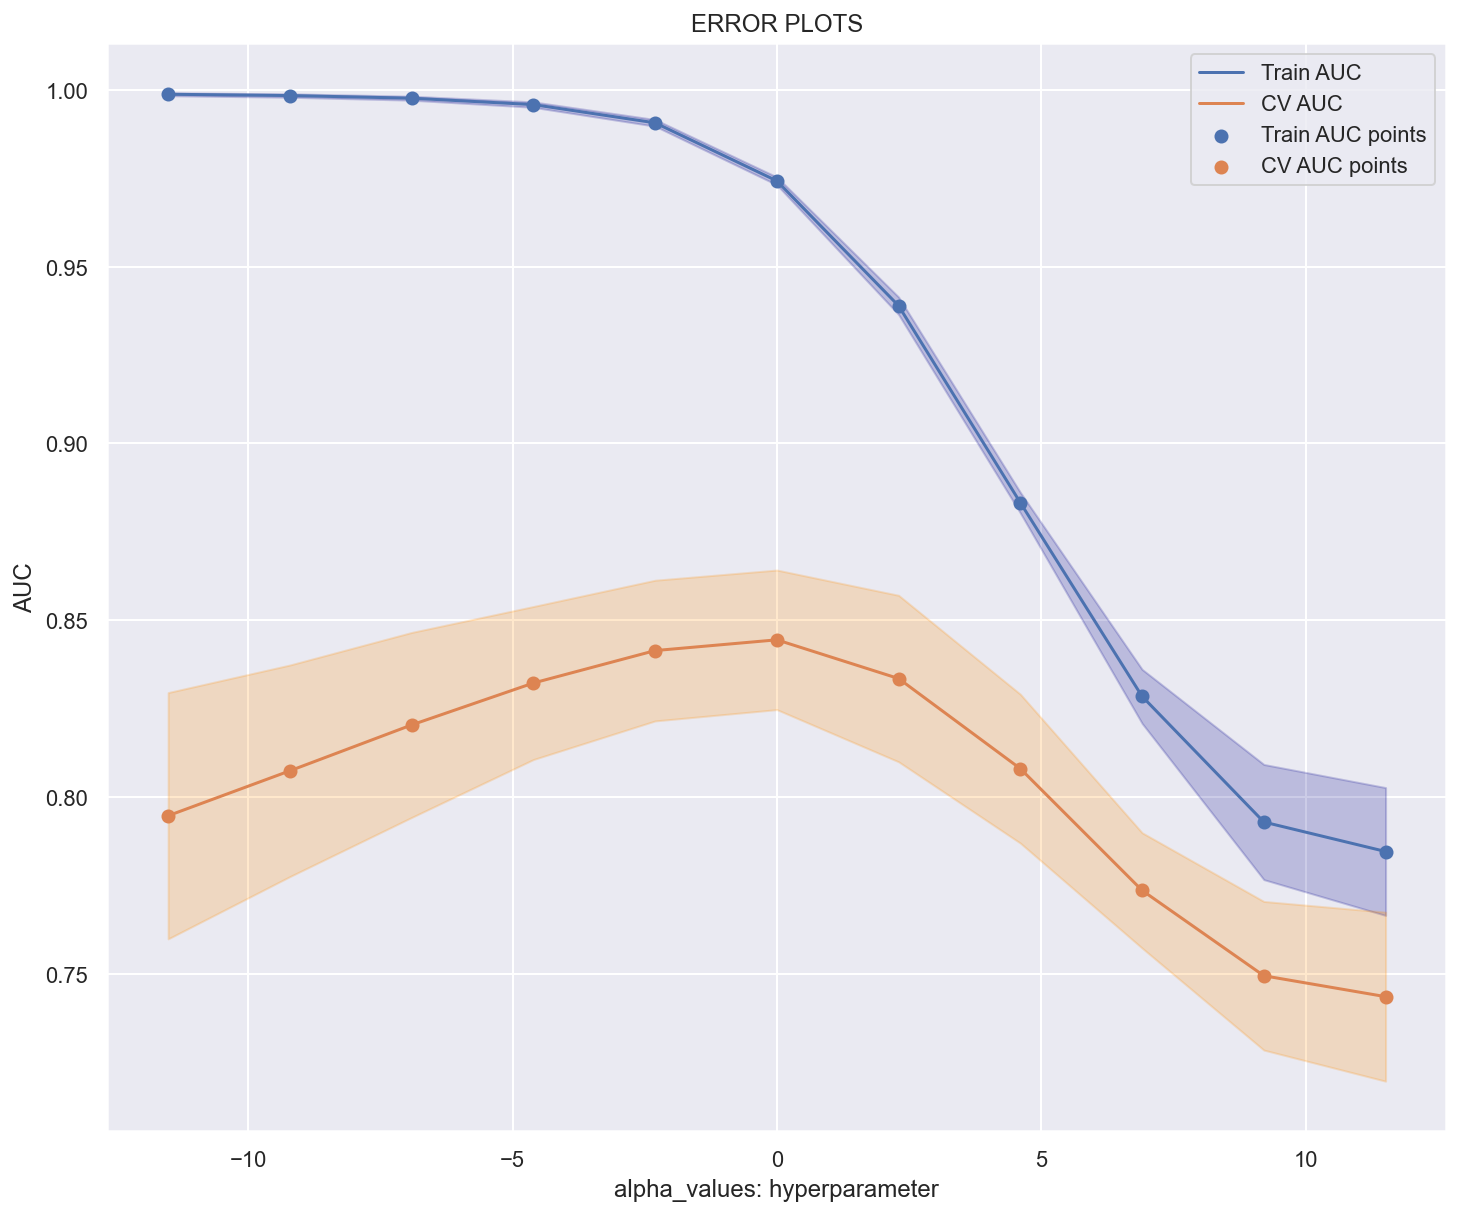

Best cross-validation score: 0.844
The best alpha from gridsearch : 1


In [392]:
def plot_error():
    alpha_values_lst = [np.log(x) for x in alpha_values]

    plt.subplots(figsize=(12,10))
    plt.plot(alpha_values_lst, train_auc, label='Train AUC')
    plt.gca().fill_between(alpha_values_lst,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

    plt.plot(alpha_values_lst, cv_auc, label='CV AUC')
    plt.gca().fill_between(alpha_values_lst,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

    plt.scatter(alpha_values_lst, train_auc, label='Train AUC points')
    plt.scatter(alpha_values_lst, cv_auc, label='CV AUC points')

    plt.legend()
    plt.xlabel("alpha_values: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()

    print("Best cross-validation score: {:.3f}".format(clf.best_score_))
    print('The best alpha from gridsearch :',best_alpha)

plot_error()

# Confusion Matrix (alpha=1)

Confusion Matrix:

[[106  44]
 [ 23 104]]
              precision    recall  f1-score   support

           0       0.82      0.71      0.76       150
           1       0.70      0.82      0.76       127

    accuracy                           0.76       277
   macro avg       0.76      0.76      0.76       277
weighted avg       0.77      0.76      0.76       277



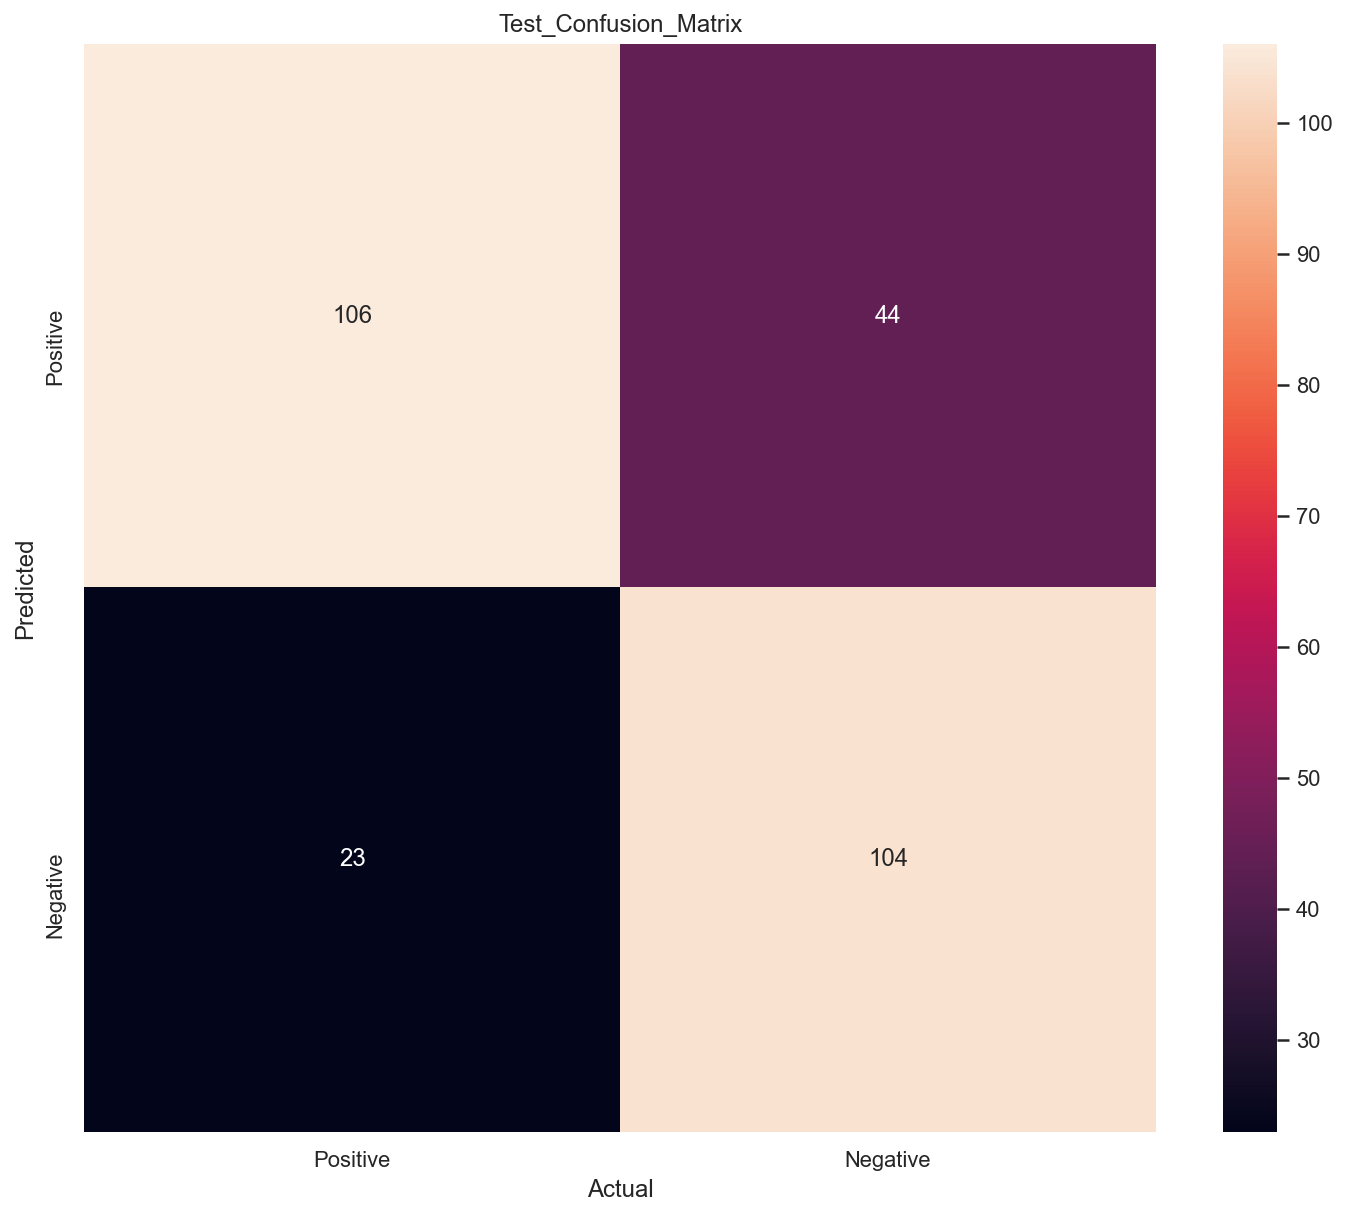

In [393]:
matrix(X_train_bow, y_train, X_test_bow, y_test, alpha=1)

***

# Preprocessing Improvement with Hyperparameter Tuning (Bag of Words)
Implemented improvements:
- Preprocessed stemmed words with N occurrences dropped.
- Hyperparameter tuning for alpha.

### Naive Bayes Considerations

- Naive Bayes is very sensitive to overfitting since it considers all the features independently of each other.
- It's also quite likely that the final number of features (words) is too high with respect to the number of instances. A low ratio instances/words causes overfitting.
The solution is to filter out words which occur less than $𝑁$ times in the data. Maybe try with several values of $𝑁$, starting with $𝑁=2$.

Fitting 5 folds for each of 11 candidates, totalling 55 fits


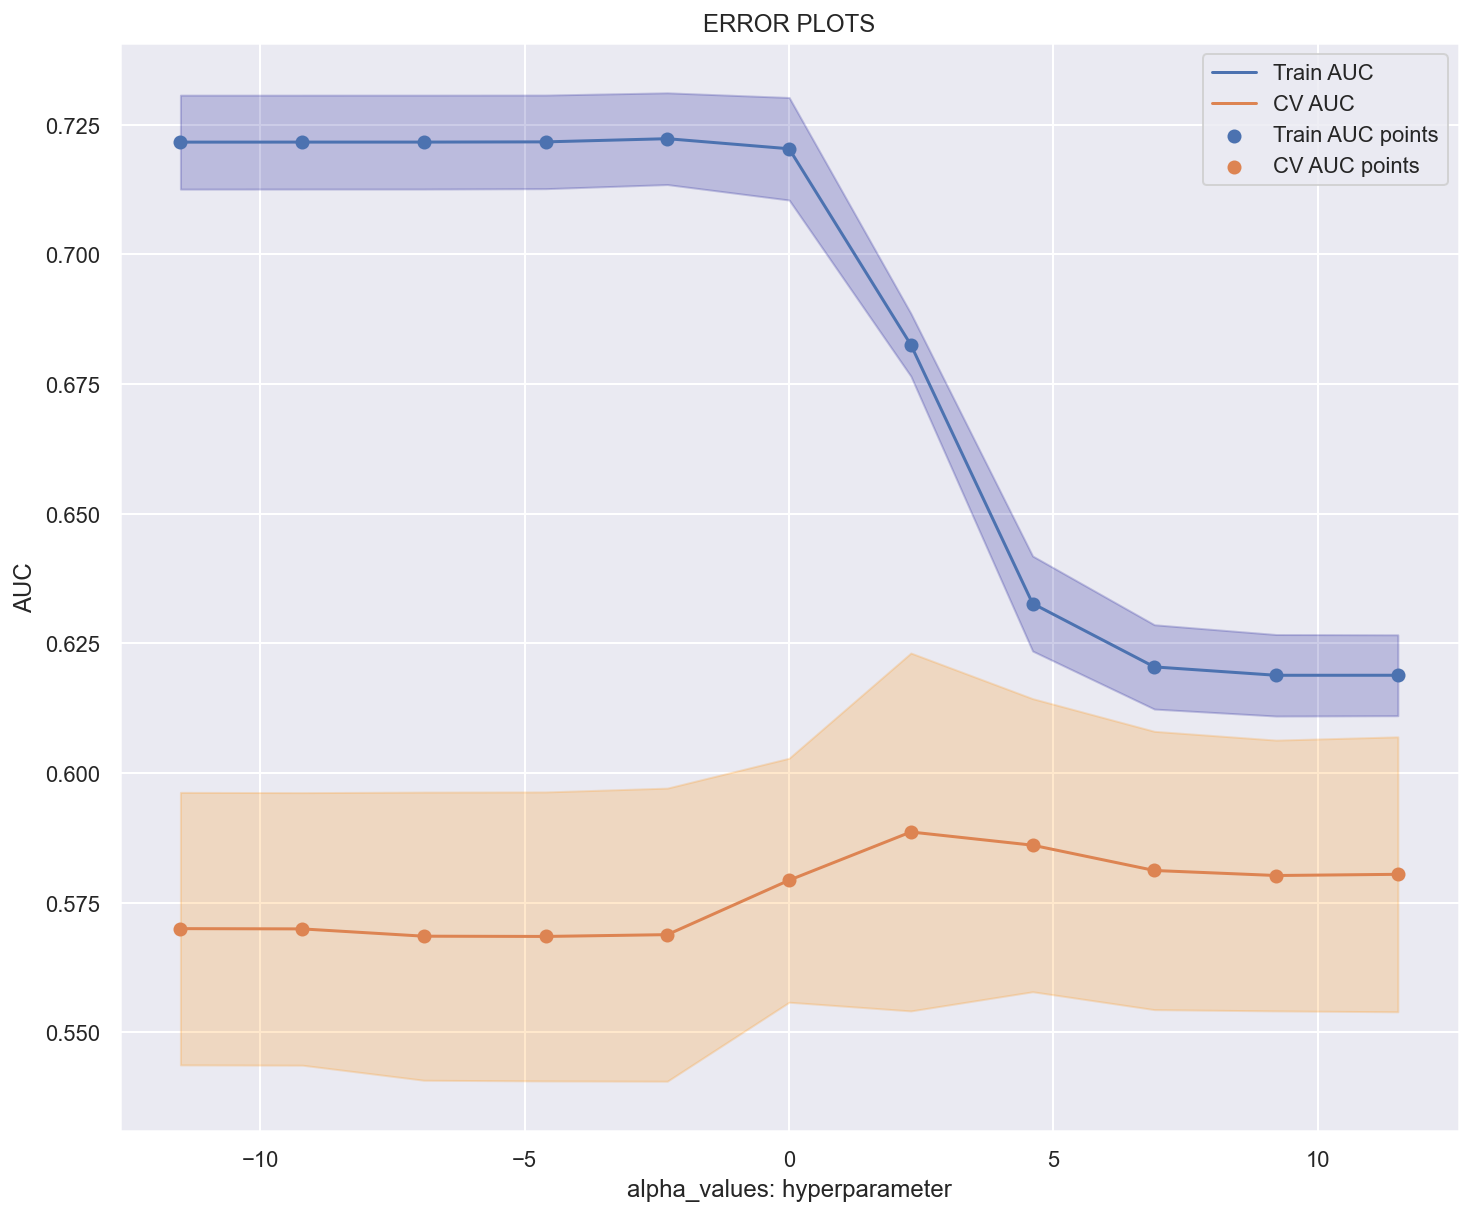

Best cross-validation score: 0.589
The best alpha from gridsearch : 10


In [394]:
def remove_word_occurrences(df, N=2):
    # Extra reduction step to remove words that occur less than N times.
    total_rows = len(df)
    df['reduced_stem_count'] = [{k:v for k,v in df['stemmed_count'][row].items() if v > N} for row in range(total_rows)]
    df['reduced_stemmed'] = [[k for k in df['reduced_stem_count'][row]] for row in range(total_rows)]
    df['reduced_stemmed_sentence'] = [' '.join(i) for i in df['reduced_stemmed']]
    return df

df = process_text('car_reviews.csv')
df = remove_word_occurrences(df, N=5)

# Sentiment target, convert to 1 for pos, 0 for neg
y = df['Sentiment'].replace('Pos', 1).replace('Neg', 0)
# Fully processed sentence
X = df['reduced_stemmed_sentence']

# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        train_size=0.8, test_size=0.2,
                                        random_state=0)

vect = CountVectorizer()

X_train_bow = vect.fit_transform(X_train)
X_test_bow = vect.transform(X_test)

alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = param_tuning(X_train_bow)
# defining train and cross_validation
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std = clf.cv_results_['std_test_score']
best_alpha = clf.best_params_['alpha']

plot_error()


# Confusion Matrix (alpha=10)

Confusion Matrix:

[[76 74]
 [56 71]]
              precision    recall  f1-score   support

           0       0.58      0.51      0.54       150
           1       0.49      0.56      0.52       127

    accuracy                           0.53       277
   macro avg       0.53      0.53      0.53       277
weighted avg       0.54      0.53      0.53       277



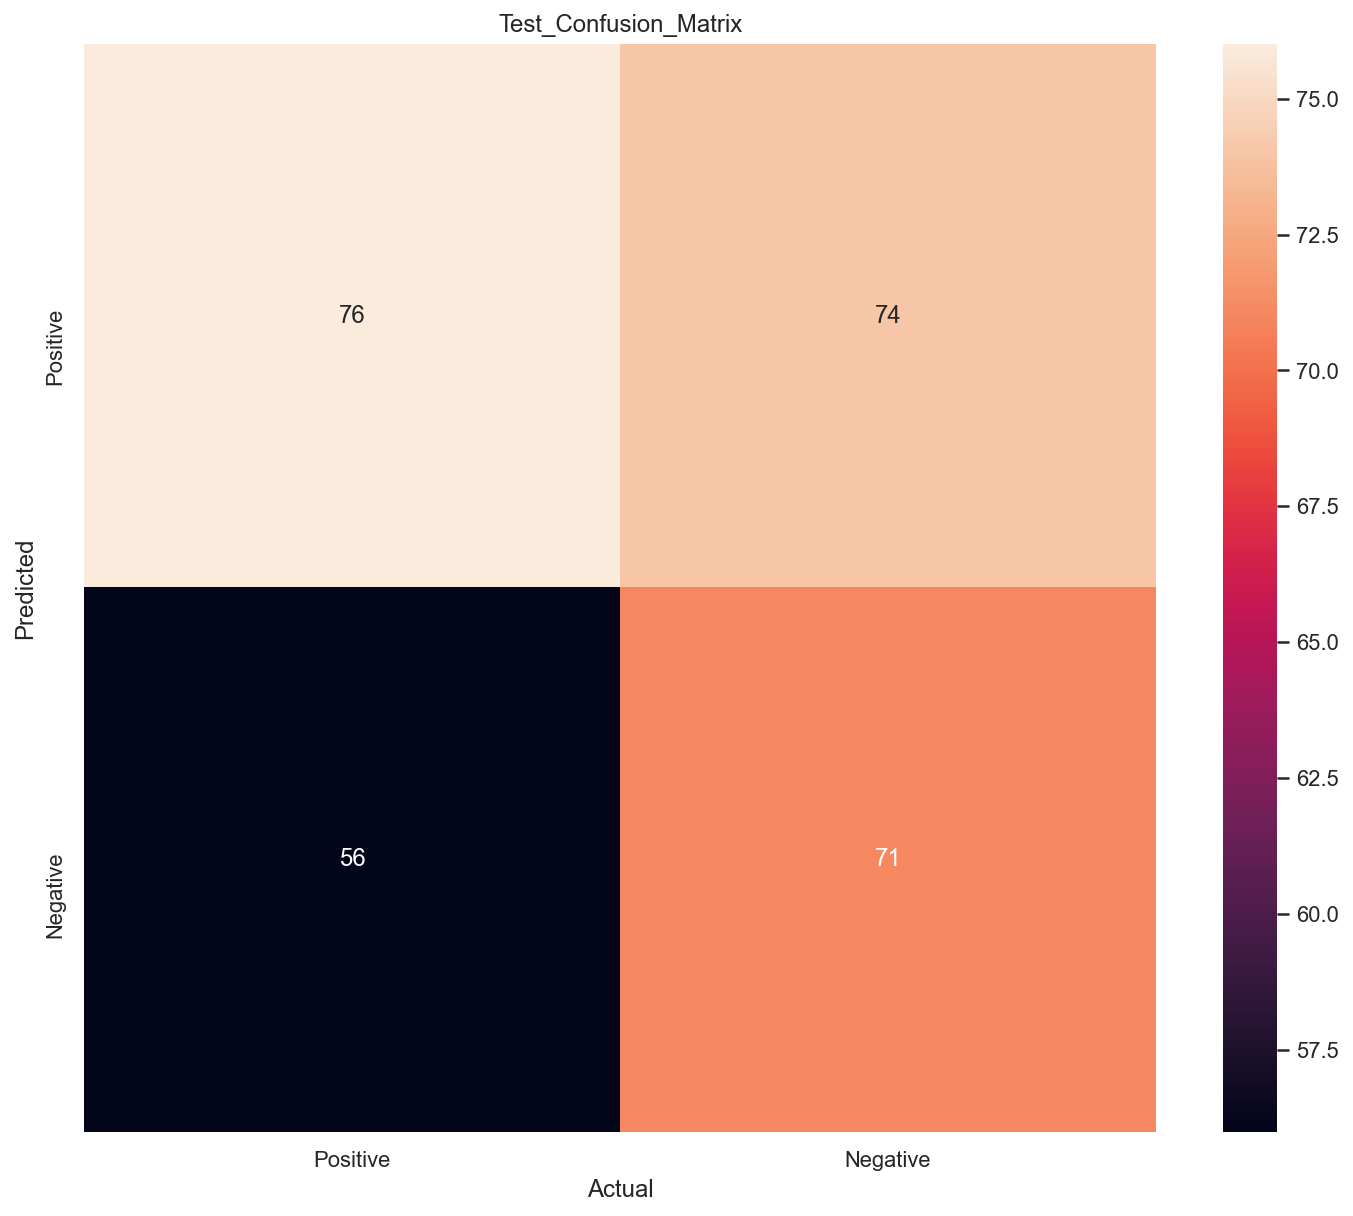

In [395]:
matrix(X_train_bow, y_train, X_test_bow, y_test, alpha=10)

***

# Improvements Using `TfidVectorizer()`

Implemented improvements:
- Preprocessed stemmed words with N occurrences dropped.
- Hyperparameter tuning for alpha.
- Use of the `TfidVectorizer()` instead of the `CountVectorizer()`


The sklearn class [TfidVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) might have a small performance increase as opposed to the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) (Bag of Words), which uses produces a sparse representation of the counts using scipy.sparse.csr_matrix. They both have equiavalent functionality, but for our small dataset the prior performs better.

Some sample features (unique words in the corpus): ['ab', 'ab brake', 'abil', 'abl', 'abl get']
The number of unique words including both unigrams and bigrams: 4519

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Fitting 5 folds for each of 11 candidates, totalling 55 fits


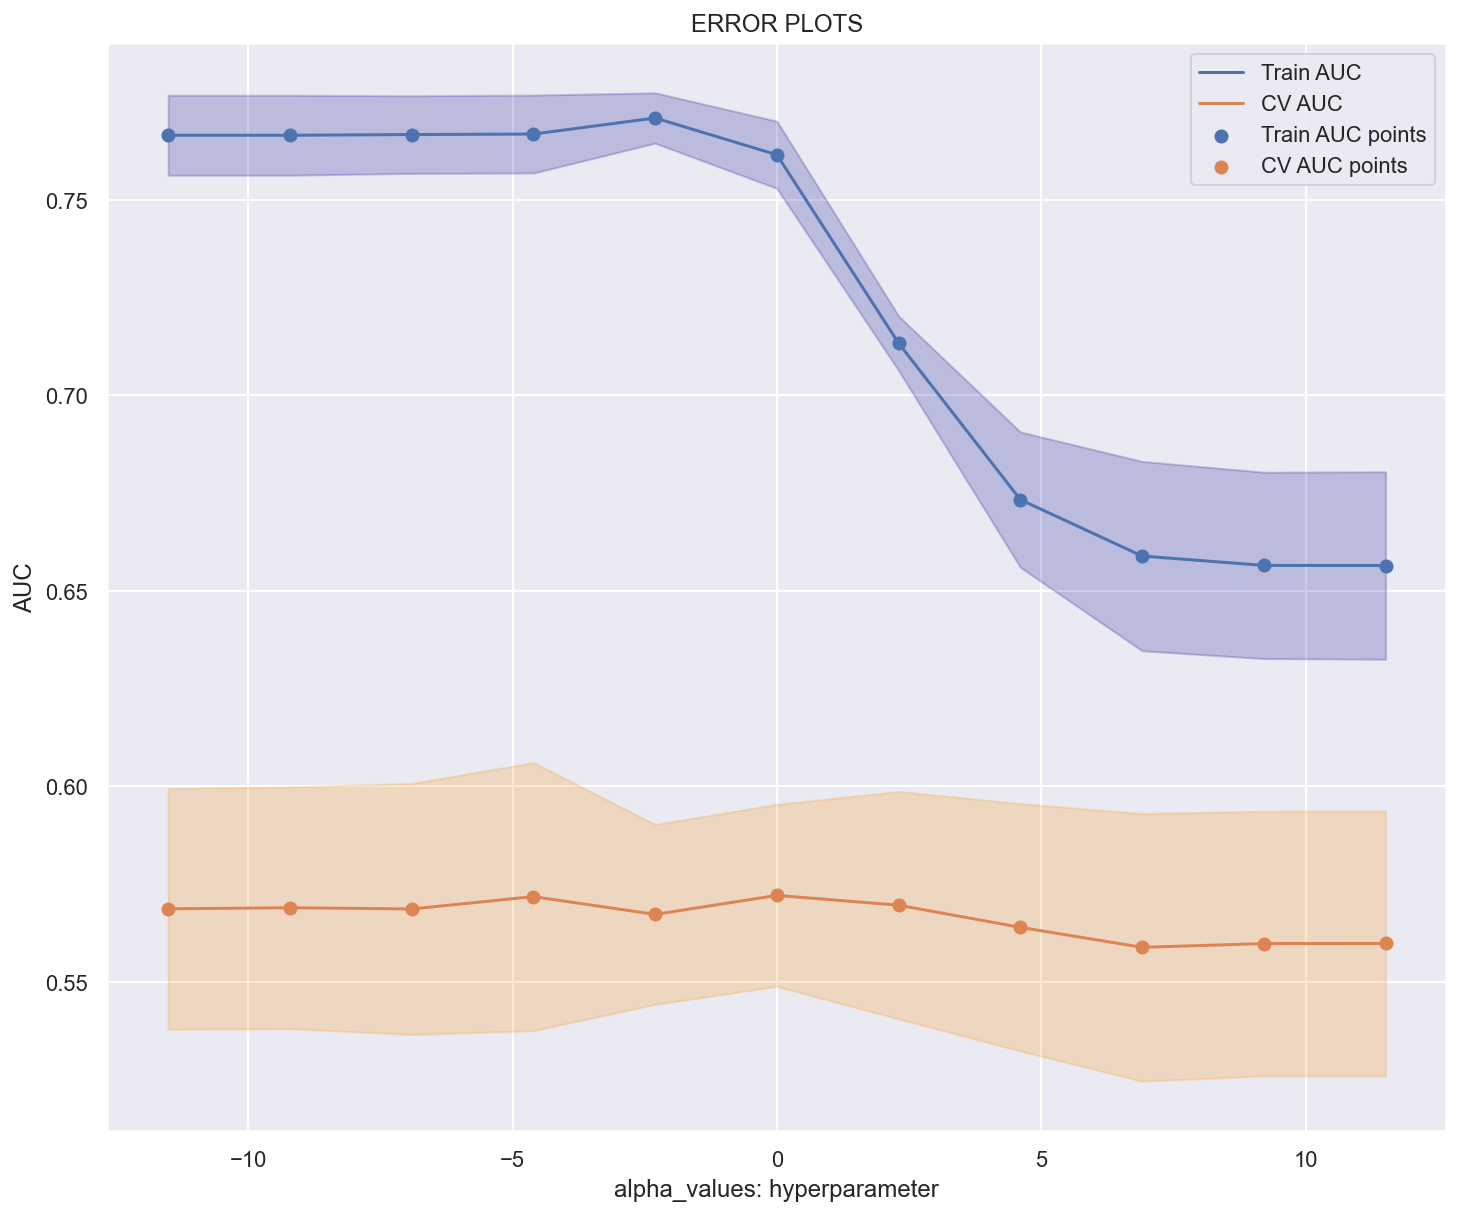

Best cross-validation score: 0.572
The best alpha from gridsearch : 1


In [396]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(df['stemmed_sentence'])
print("Some sample features (unique words in the corpus):",tf_idf_vect.get_feature_names()[0:5])
print('='*100)

final_tf_idf = tf_idf_vect.transform(df['reduced_stemmed_sentence'])

print("The number of unique words including both unigrams and bigrams:", final_tf_idf.get_shape()[1])
print()

# Sentiment target, convert to 1 for pos, 0 for neg
y_tf = df['Sentiment'].replace('Pos', 1).replace('Neg', 0)
# Fully processed sentence
X_tf = final_tf_idf

# Break off validation set from training data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y_tf, 
                                        train_size=0.8, test_size=0.2,
                                        random_state=0)
clf = param_tuning(X_train_bow)
alpha_values = [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
clf = param_tuning(X_train_tf)
# defining train and cross_validation
train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std = clf.cv_results_['std_test_score']
best_alpha = clf.best_params_['alpha']

plot_error()

# Confusion Matrix (alpha=1)

Confusion Matrix:

[[ 49 101]
 [ 33  94]]
              precision    recall  f1-score   support

           0       0.60      0.33      0.42       150
           1       0.48      0.74      0.58       127

    accuracy                           0.52       277
   macro avg       0.54      0.53      0.50       277
weighted avg       0.54      0.52      0.50       277



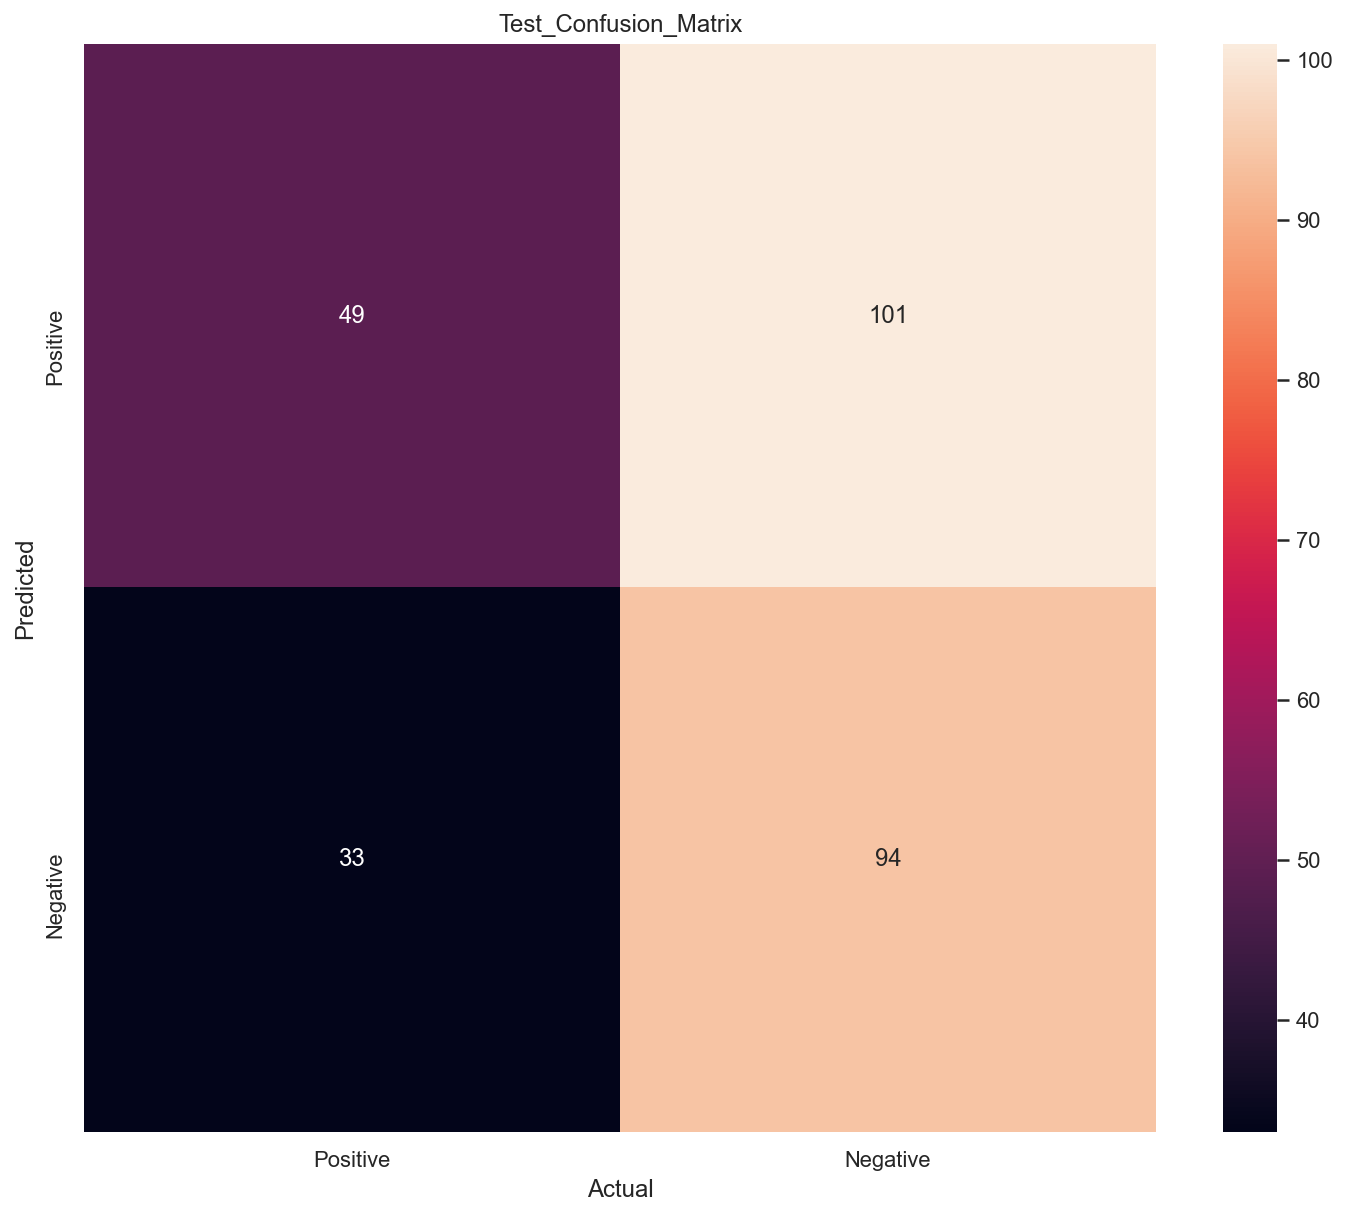

In [397]:
matrix(X_train_tf, y_train_tf, X_test_tf, y_test_tf, alpha=1)

***
# Using the `ComplementNB()` Model
Implemented potential improvements:
- Preprocessed stemmed words with N occurrences dropped.
- Hyperparameter tuning for alpha.
- Use of the `TfidVectorizer()` instead of the `CountVectorizer()`
- Use of the `ComplementNB()` instead of the `MultiNomialNB()`

`ComplementNB()` implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks.



Confusion Matrix:

[[133  17]
 [101  26]]
              precision    recall  f1-score   support

           0       0.57      0.89      0.69       150
           1       0.60      0.20      0.31       127

    accuracy                           0.57       277
   macro avg       0.59      0.55      0.50       277
weighted avg       0.59      0.57      0.52       277



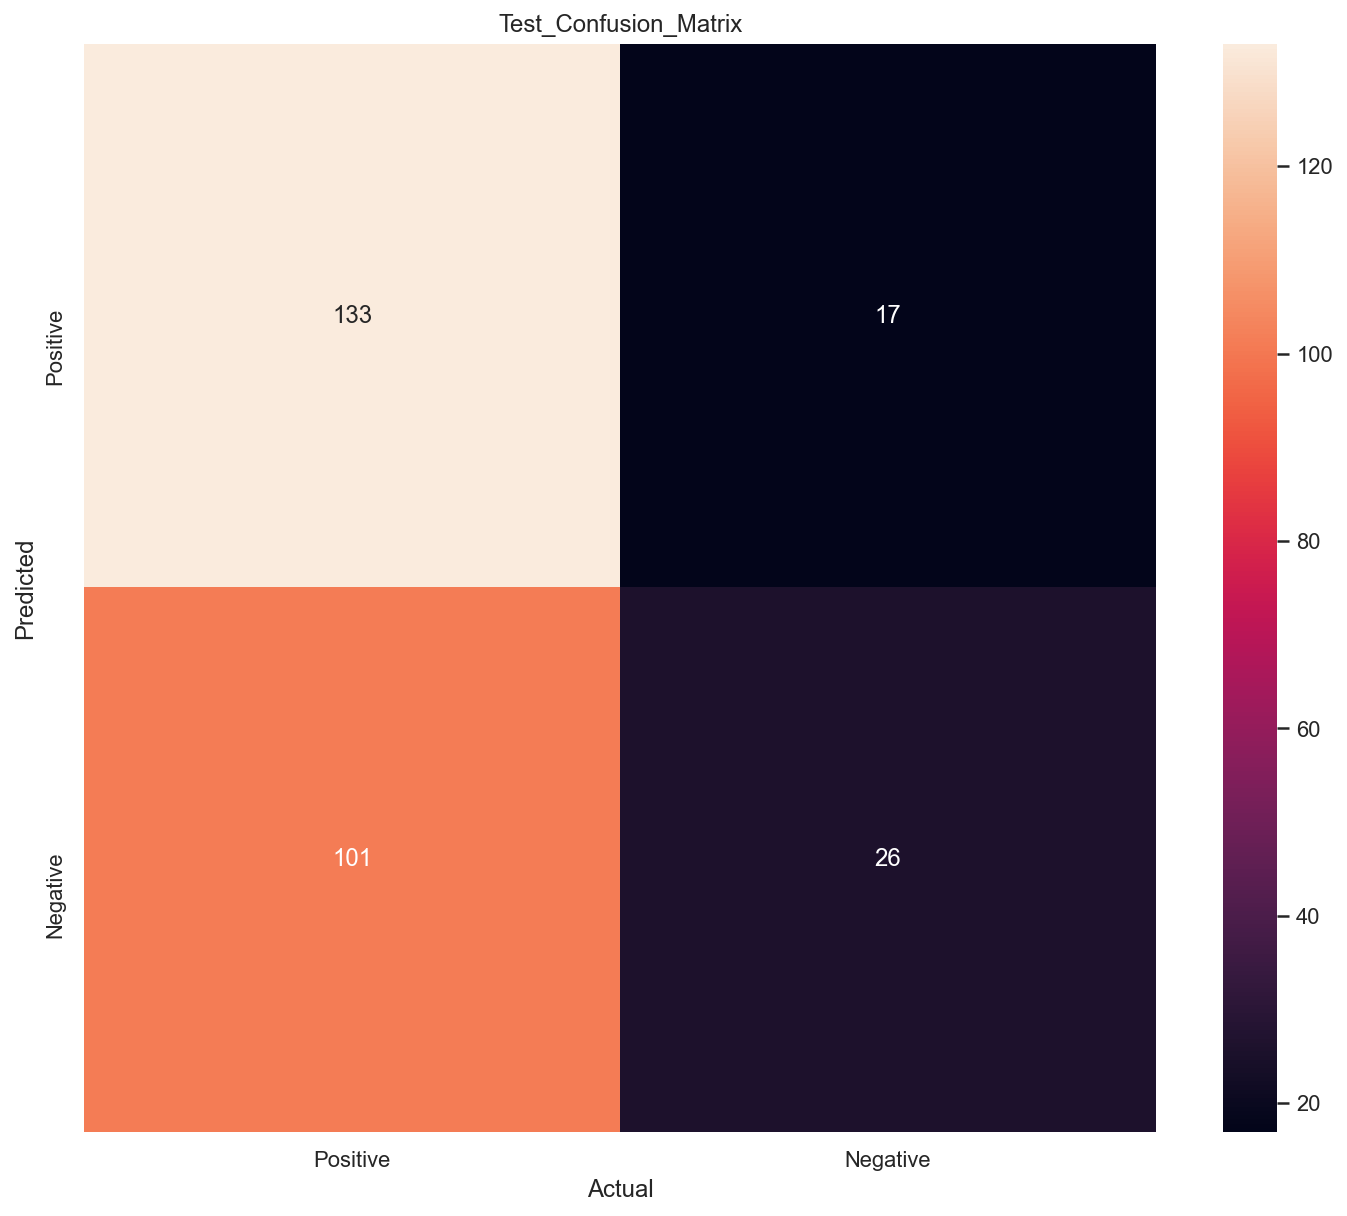

Confusion Matrix:

[[136  14]
 [104  23]]
              precision    recall  f1-score   support

           0       0.57      0.91      0.70       150
           1       0.62      0.18      0.28       127

    accuracy                           0.57       277
   macro avg       0.59      0.54      0.49       277
weighted avg       0.59      0.57      0.51       277



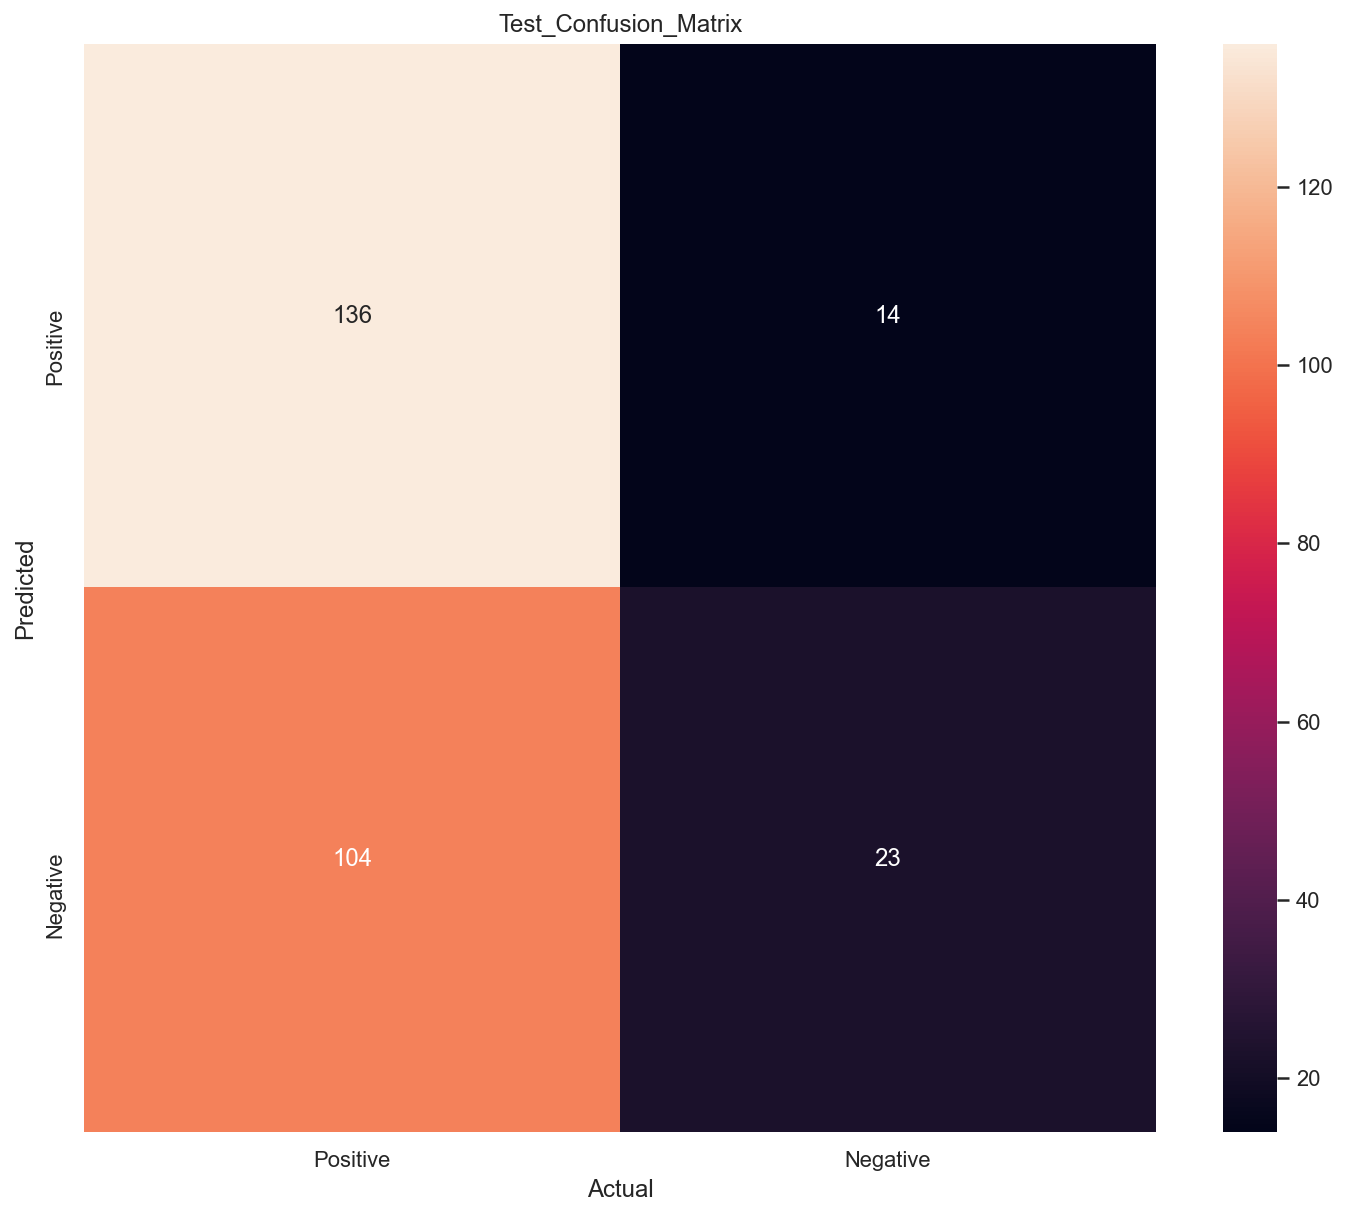

In [400]:
def matrix_comp(X_train,y_train,X_test,y_test):

    # Run the model on the training set
    model = ComplementNB(alpha=10)
    model.fit(X_train, y_train)

    # Test the model with the test set
    predict = model.predict(X_test)

    # Save the model
    pickle.dump(model, open('model.pkl','wb'))

    # Define the confusion matrix
    conf_mat = confusion_matrix(y_test, predict)
    print('Confusion Matrix:\n')
    print(conf_mat)
    class_label = ["Positive", "Negative"]
    df = pd.DataFrame(conf_mat, index=class_label, columns=class_label)

    # Get the classification report
    report = classification_report(y_test,predict)
    print(report)

    # Plot the confusion matrix
    plt.subplots(figsize=(12,10))
    sns.heatmap(df, annot=True, fmt="d")
    plt.title("Test_Confusion_Matrix")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.show()

# Using Tfid
matrix_comp(X_train_tf, y_train_tf, X_test_tf, y_test_tf)
# Using Bag of Words
matrix_comp(X_train_bow, y_train, X_test_bow, y_test)

# Using `DictVectorizer()`
Implemented potential improvements:
- Preprocessed stemmed words with N occurrences dropped.
- Hyperparameter tuning for alpha.
- Use of the `DictVectorizer()` instead of the `CountVectorizer()` and `TfidVectorizer()`.
- Use of `MultiNomialNB()` for the model.

Confusion Matrix:

[[ 49 101]
 [ 29  98]]
              precision    recall  f1-score   support

           0       0.63      0.33      0.43       150
           1       0.49      0.77      0.60       127

    accuracy                           0.53       277
   macro avg       0.56      0.55      0.52       277
weighted avg       0.57      0.53      0.51       277



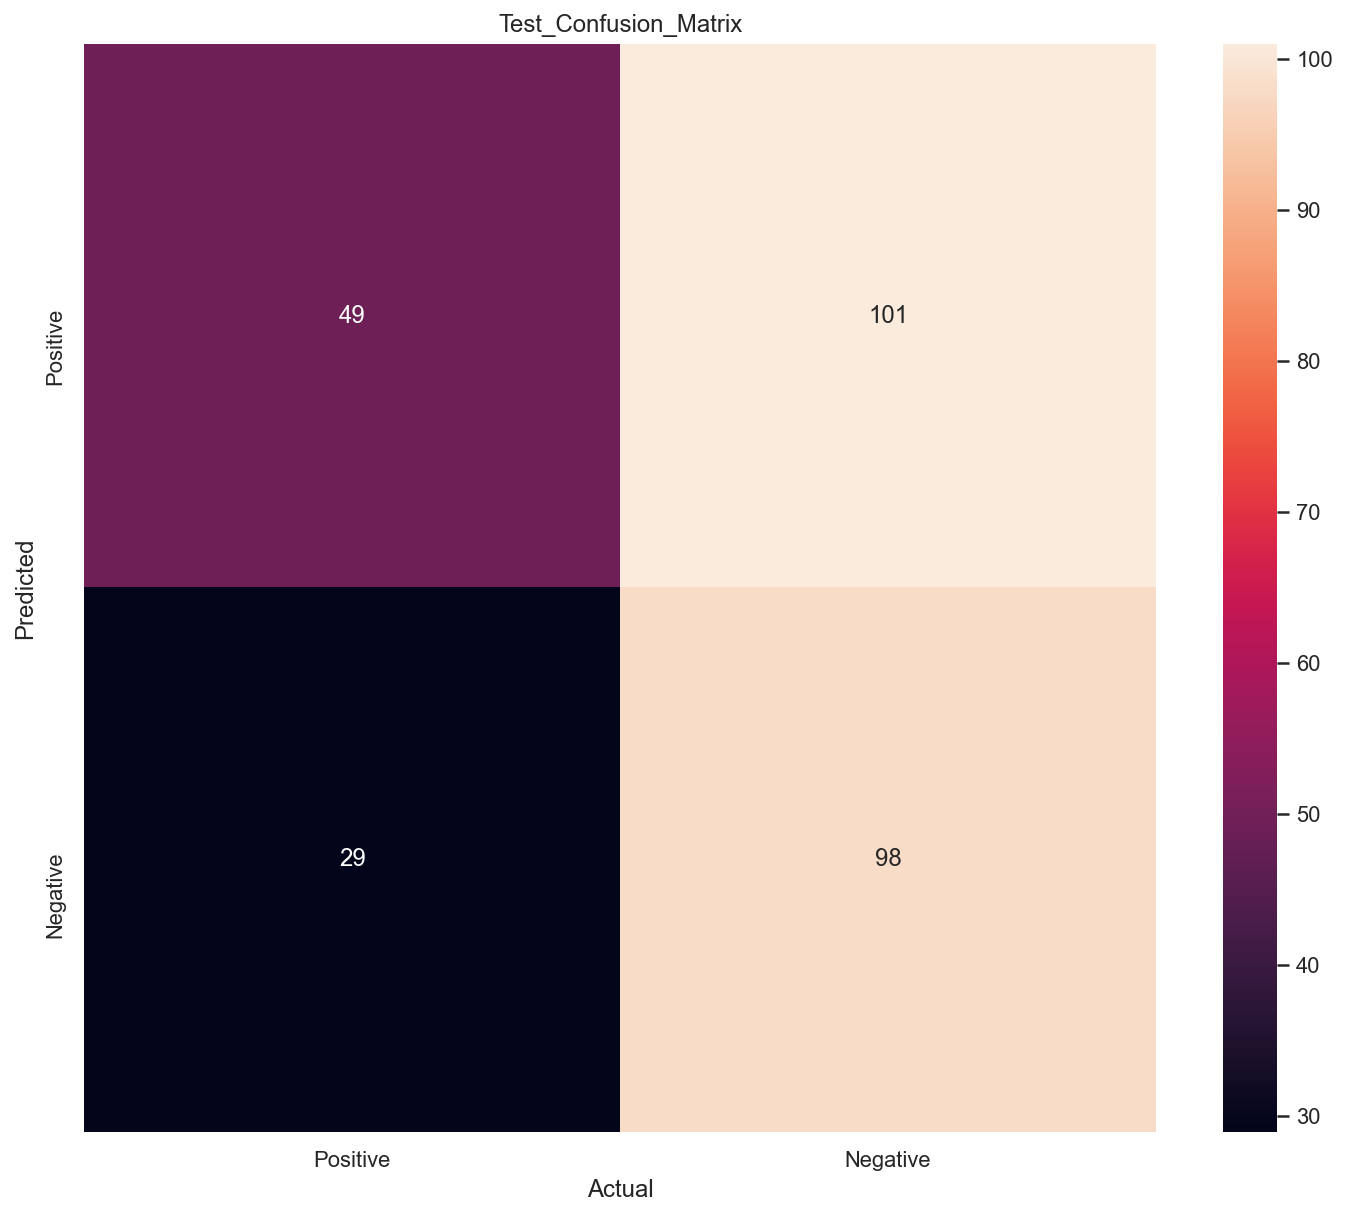

In [399]:
dv = DictVectorizer(sparse=False)
X_dv = dv.fit_transform(df['reduced_stem_count'])
# Sentiment target, convert to 1 for pos, 0 for neg
y_dv = df['Sentiment'].replace('Pos', 1).replace('Neg', 0)
# Break off validation set from training data
X_train_dv, X_test_dv, y_train_dv, y_test_dv = train_test_split(X_dv, y_dv, 
                                        train_size=0.8, test_size=0.2,
                                        random_state=0)
matrix(X_train_dv, y_train_dv, X_test_dv, y_test_dv, alpha=1)


# Conclusions

Classification report explained:

- The recall means "how many of this class you find over the whole number of elements of this class"
- The precision will be "how many are correctly classified among that class"
- The f1-score is the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset 
- 0 stands for 'Negative'
- 1 stands for 'Positive'

Confusion Matrix:
$\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$ 

The best confusion matrix has a low:
- False Positive: You predicted positive and it’s false. (Type 1 Error)
- False Negative: You predicted negative and it’s false. (Type 2 Error)

and a high:
- True Positive: You predicted positive and it’s true.
- True Negative: You predicted negative and it’s true.


# Model: `MultinomialNB()`

## Task 1 
Base Model

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.80   | 0.75     | 0.77    | 150 |
| 1            | 0.73   | 0.77     | 0.75    | 127 |
| accuracy     |    |       |    0.76     |   277  |
| macro avg    | 0.76   | 0.76     | 0.76    | 277 |
| weighted avg | 0.76   | 0.76     | 0.76    | 277 |

Confusion Matrix:
$\begin{bmatrix} 113 & 37 \\ 29 & 98 \end{bmatrix}$


## Task 2 - Improve the Model

### - Hyperparameter Tuning Using `KFold()` and `GridSearch()`
Implemented improvements:
- Preprocessed stemmed words with N occurrences dropped.
- Hyperparameter tuning for alpha=1.

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.82   | 0.71     | 0.76    | 150 |
| 1            | 0.70   | 0.82     | 0.76    | 127 |
| accuracy     |    |      |    0.76     |   277  |
| macro avg    | 0.76   | 0.76     | 0.76    | 277 |
| weighted avg | 0.77   | 0.76     | 0.76    | 277 |

Confusion Matrix:
$\begin{bmatrix} 106 & 44 \\ 23 & 104 \end{bmatrix}$


### - Preprocessing Improvement using `PorterStemmer()`
Implemented improvements:
- Preprocessed stemmed words with N < 2 occurrences dropped.
- Hyperparameter tuning for alpha=10.

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.71   | 0.65     | 0.68    | 150 |
| 1            | 0.62   | 0.69     | 0.65    | 127 |
| accuracy     |    |       |     0.66    |  277   |
| macro avg    | 0.66   | 0.67     | 0.66    | 277 |
| weighted avg | 0.67   | 0.66     | 0.66    | 277 |

Confusion Matrix:
$\begin{bmatrix} 97 & 53 \\ 40 & 87 \end{bmatrix}$


### - Using `TfidVectorizer()`
Implemented improvements:
- Hyperparameter tuning for alpha=0.1.
- Use of the `TfidVectorizer()` instead of the `CountVectorizer()`

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.91   | 0.69     | 0.79    | 150 |
| 1            | 0.72   | 0.92     | 0.81    | 127 |
| accuracy     |    |      |    0.80     |   277  |
| macro avg    | 0.82   | 0.81     | 0.80    | 277 |
| weighted avg | 0.82   | 0.80     | 0.80    | 277 |

Confusion Matrix:
$\begin{bmatrix} 110 & 40 \\ 11 & 116 \end{bmatrix}$

Implemented improvements:
- Hyperparameter tuning for alpha=1.
- Use of the `TfidVectorizer()` instead of the `CountVectorizer()`
- Preprocessed stemmed words with N < 2 occurrences dropped.

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.74   | 0.59     | 0.66    | 150 |
| 1            | 0.61   | 0.76     | 0.68    | 127 |
| accuracy     |    |      |   0.67      |   277   |
| macro avg    | 0.68   | 0.67     | 0.67    | 277 |
| weighted avg | 0.68   | 0.67     | 0.67    | 277 |

Confusion Matrix:
$\begin{bmatrix} 89 & 61 \\ 31 & 96 \end{bmatrix}$

### - Using `DictVectorizer()`
Implemented improvements:
- Preprocessed stemmed words with N < 2 occurrences dropped.
- Hyperparameter tuning for alpha=10.
- Use of the `DictVectorizer()` instead of the `CountVectorizer()`

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.71   | 0.61     | 0.66    | 150 |
| 1            | 0.61   | 0.70     | 0.65    | 127 |
| accuracy     |    |       |     0.65    |  277   |
| macro avg    | 0.66   | 0.66     | 0.65    | 277 |
| weighted avg | 0.66   | 0.65     | 0.65    | 277 |

Confusion Matrix:
$\begin{bmatrix} 92 & 58 \\ 38 & 89 \end{bmatrix}$

For this use case, the `TfidVectorizer()` with `alpha=10` allows our model `MultinomialNB()` to perform better.


# Model `ComplementNB()`

[ComplementNB()](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB) sees a slight decrease in precision, but it shines with imbalanced data sets, and ours is fairly balanced! Should this not be the case with other test train splits, this model should beat [MultinomialNB()](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

Implemented potential improvements:
- Preprocessed stemmed words with N < 2 occurrences dropped.
- Hyperparameter tuning for alpha.
- Use of the `TfidVectorizer()` instead of the `CountVectorizer()`
- Use of the `ComplementNB()` instead of the `MultiNomialNB()`

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.92   | 0.67     | 0.77    | 150 |
| 1            | 0.70   | 0.93     | 0.80    | 127 |
| accuracy     |    |       |   0.79      |   277  |
| macro avg    | 0.81   | 0.80     | 0.79    | 277 |
| weighted avg | 0.82   | 0.79     | 0.78    | 277 |

Confusion Matrix:
$\begin{bmatrix} 100 & 50 \\ 9 & 118 \end{bmatrix}$

Implemented potential improvements:
- Preprocessed stemmed words with N < 2 occurrences dropped.
- Hyperparameter tuning for alpha.
- Use of the `CountVectorizer()` instead of the `TfidVectorizer()`
- Use of the `ComplementNB()` instead of the `MultiNomialNB()`

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.71   | 0.69     | 0.70    | 150 |
| 1            | 0.64   | 0.67     | 0.66    | 127 |
| accuracy     |    |      |     0.68     |  277    |
| macro avg    | 0.68   | 0.68     | 0.68    | 277 |
| weighted avg | 0.68   | 0.68     | 0.68    | 277 |

Confusion Matrix:
$\begin{bmatrix} 103 & 47 \\ 42 & 85 \end{bmatrix}$


# `Best Results`

### - Using `TfidVectorizer()`
Implemented improvements:
- Hyperparameter tuning for alpha=0.1.
- Use of the `TfidVectorizer()` instead of the `CountVectorizer()`
- No extra preprocessing step to remove word occurrences.

|     | precision | recall | f1-score |  support   |
|--------------|--------|----------|---------|-----|
| 0            | 0.91   | 0.69     | 0.79    | 150 |
| 1            | 0.72   | 0.92     | 0.81    | 127 |
| accuracy     |    |      |    0.80     |   277  |
| macro avg    | 0.82   | 0.81     | 0.80    | 277 |
| weighted avg | 0.82   | 0.80     | 0.80    | 277 |

Confusion Matrix:
$\begin{bmatrix} 110 & 40 \\ 11 & 116 \end{bmatrix}$
